Zbiór danych: https://www.kaggle.com/datasets/krzysztofjamroz/apartment-prices-in-poland?resource=download

Dataset zawiera informacje o nieruchomościach na sprzedaż w Polsce z czerwca 2024r  

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor

data_path = 'apartments_pl_2024_06.csv'

apartments_data = pd.read_csv(data_path)
apartments_data.drop(axis=1, inplace=True, columns='id')

num_rows, num_columns = apartments_data.shape

print(f"Liczba rekordów (wierszy): {num_rows}")
print(f"Liczba cech (kolumn): {num_columns}")

pd.set_option('display.max_columns', None)
print(apartments_data.head())

Liczba rekordów (wierszy): 21501
Liczba cech (kolumn): 27
       city               type  squareMeters  rooms  floor  floorCount  \
0  szczecin       blockOfFlats         47.00    2.0    6.0        12.0   
1  szczecin  apartmentBuilding         88.22    3.0    1.0         2.0   
2  szczecin  apartmentBuilding        117.00    5.0    4.0         4.0   
3  szczecin       blockOfFlats         33.31    1.0    1.0         4.0   
4  szczecin       blockOfFlats         56.00    3.0    7.0         7.0   

   buildYear   latitude  longitude  centreDistance  poiCount  schoolDistance  \
0     1981.0  53.428544  14.552812            0.79      67.0           0.288   
1     2000.0  53.449093  14.516844            4.09       0.0           0.509   
2        NaN  53.443096  14.561348            2.19      10.0           0.216   
3     1963.0  53.436100  14.541200            1.93      39.0           0.073   
4     2018.0  53.447465  14.557811            2.68      10.0           0.268   

   clinicDistanc

In [34]:
from random import sample, randint

# deleting random data from the dataset
for col in apartments_data.columns[:-1]:
    present_column_values = apartments_data[col].notnull()
    non_missing_indices = apartments_data[present_column_values].index.tolist()

    if apartments_data[col].isnull().sum() < 0.03 * num_rows:
        num_to_remove = int(len(non_missing_indices) * randint(1, 10) / 100)
        indices_to_remove = sample(non_missing_indices, num_to_remove)
        apartments_data.loc[indices_to_remove, col] = None


Zbiór zawiera 21501 rekordów, liczba cech w całym zbiorze wynosi 28. Do przeprowadzenia regresji zostaną wykorzystane następujące cechy:

1. squareMeters – metraż mieszkania w metrach kwadratowych
2. city – miasto, w którym znajduje się mieszkanie
3. rooms – liczba pokoi w mieszkaniu
4. floor – piętro, na którym znajduje się lokal
5. floorCount – liczba pięter w całym budynku
6. buildYear – rok budowy nieruchomości
7. latitude – szerokość geograficzna mieszkania
8. longitude – długość geograficzna mieszkania
9. centreDistance – odległość od centrum miasta (w km)
10. poiCount – liczba punktów zainteresowania w pobliżu (np. sklepy, usługi)
11. schoolDistance – odległość do najbliższej szkoły (w km)
12. clinicDistance – odległość do najbliższej przychodni (w km)
13. postOfficeDistance – odległość do najbliższej poczty (w km)
14. kindergartenDistance – odległość do najbliższego przedszkola (w km)
15. restaurantDistance – odległość do najbliższej restauracji (w km)
16. collegeDistance – odległość do najbliższej uczelni wyższej (w km)
17. pharmacyDistance – odległość do najbliższej apteki (w km)
18. hasElevator – czy mieszkanie znajduje się w budynku z windą (tak/nie)
19. hasParkingSpace – czy mieszkanie posiada miejsce parkingowe (tak/nie)
20. hasStorageRoom – czy mieszkanie posiada komórkę lokatorską (tak/nie)
21. hasBalcony – czy mieszkanie posiada balkon (tak/nie)
22. hasSecurity – czy budynek posiada monitoring lub ochronę (tak/nie)
23. type – typ nieruchomości (blockOfFlats, apartmentBuilding, tenement)
24. buildingMaterial – materiał, z którego wykonano budynek (brick, concreteSlab)
25. ownership – forma własności (condominium, cooperative, udział)
26. condition – stan techniczny lokalu (low, standard, premium)
27. price – cena mieszkania w złotych

Zbiór posłuży do przeprowadzenia regresji cen mieszkań, z wykorzystaniem powyższych cech.

In [35]:
selected_columns = [
    'city', 'type', 'squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear',
    'latitude', 'longitude', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance',
    'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance',
    'pharmacyDistance', 'ownership', 'buildingMaterial', 'condition', 'hasParkingSpace',
    'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom', 'price'
]

missing_values = apartments_data[selected_columns].isnull().sum()

missing_percentage = (missing_values / len(apartments_data) * 100).round(2).astype(str) + "%"

print("Brakujące wartości dla wszystkich cech:")
print(missing_percentage)


Brakujące wartości dla wszystkich cech:
city                      2.0%
type                    20.45%
squareMeters              2.0%
rooms                     8.0%
floor                   16.62%
floorCount               6.91%
buildYear               15.72%
latitude                  4.0%
longitude                 6.0%
centreDistance            7.0%
poiCount                  9.0%
schoolDistance           3.05%
clinicDistance           6.27%
postOfficeDistance       2.09%
kindergartenDistance    10.08%
restaurantDistance       3.14%
collegeDistance          4.66%
pharmacyDistance         9.13%
ownership                 4.0%
buildingMaterial        40.89%
condition               74.05%
hasParkingSpace          10.0%
hasBalcony                1.0%
hasElevator              4.46%
hasSecurity               1.0%
hasStorageRoom            5.0%
price                     0.0%
dtype: object


In [36]:
error_counts = {}

valid_values = {
    "hasElevator": ["yes", "no"],
    "hasParkingSpace": ["yes", "no"],
    "hasStorageRoom": ["yes", "no"],
    "type": ["blockOfFlats", "apartmentBuilding", "tenement"],
    "buildingMaterial": ["brick", "concreteSlab"],
    "hasSecurity": ["yes", "no"],
    "hasBalcony": ["yes", "no"],
    "ownership": ["condominium", "udział", "cooperative"],
    "condition": ["premium", "low"]
}

for col, valid in valid_values.items():
    invalid_values = apartments_data[~apartments_data[col].isin(valid)][col].dropna()
    error_counts[col] = len(invalid_values)

invalid_city = apartments_data['city'].str.strip() == ""

valid_ranges = {
    "squareMeters": (10, 500),
    "rooms": (1, 10),
    "floor": (0, 50),
    "floorCount": (1, 50),
    "buildYear": (1800, 2025),
    "centreDistance": (0, 100),
    "poiCount": (0, 500),
    "schoolDistance": (0, 100),
    "clinicDistance": (0, 100),
    "postOfficeDistance": (0, 100),
    "kindergartenDistance": (0, 100),
    "restaurantDistance": (0, 100),
    "collegeDistance": (0, 100),
    "pharmacyDistance": (0, 100),
    "latitude": (-90, 90),
    "longitude": (-180, 180),
    "price": (50000, 5000000)
}

for col, (min_val, max_val) in valid_ranges.items():
    invalid_values = apartments_data[
        (apartments_data[col] < min_val) | (apartments_data[col] > max_val)
        ][col]
    error_counts[col] = len(invalid_values)

total_rows = len(apartments_data)
for col, count in error_counts.items():
    percent = round((count / total_rows) * 100, 2)
    print(f"{col.ljust(20)} {str(count).ljust(5)} ({percent}%)")

hasElevator          0     (0.0%)
hasParkingSpace      0     (0.0%)
hasStorageRoom       0     (0.0%)
type                 0     (0.0%)
buildingMaterial     0     (0.0%)
hasSecurity          0     (0.0%)
hasBalcony           0     (0.0%)
ownership            0     (0.0%)
condition            0     (0.0%)
squareMeters         0     (0.0%)
rooms                0     (0.0%)
floor                0     (0.0%)
floorCount           0     (0.0%)
buildYear            0     (0.0%)
centreDistance       0     (0.0%)
poiCount             0     (0.0%)
schoolDistance       0     (0.0%)
clinicDistance       0     (0.0%)
postOfficeDistance   0     (0.0%)
kindergartenDistance 0     (0.0%)
restaurantDistance   0     (0.0%)
collegeDistance      0     (0.0%)
pharmacyDistance     0     (0.0%)
latitude             0     (0.0%)
longitude            0     (0.0%)
price                0     (0.0%)


Zbiór nie zawiera niepoprawnych wartości.  

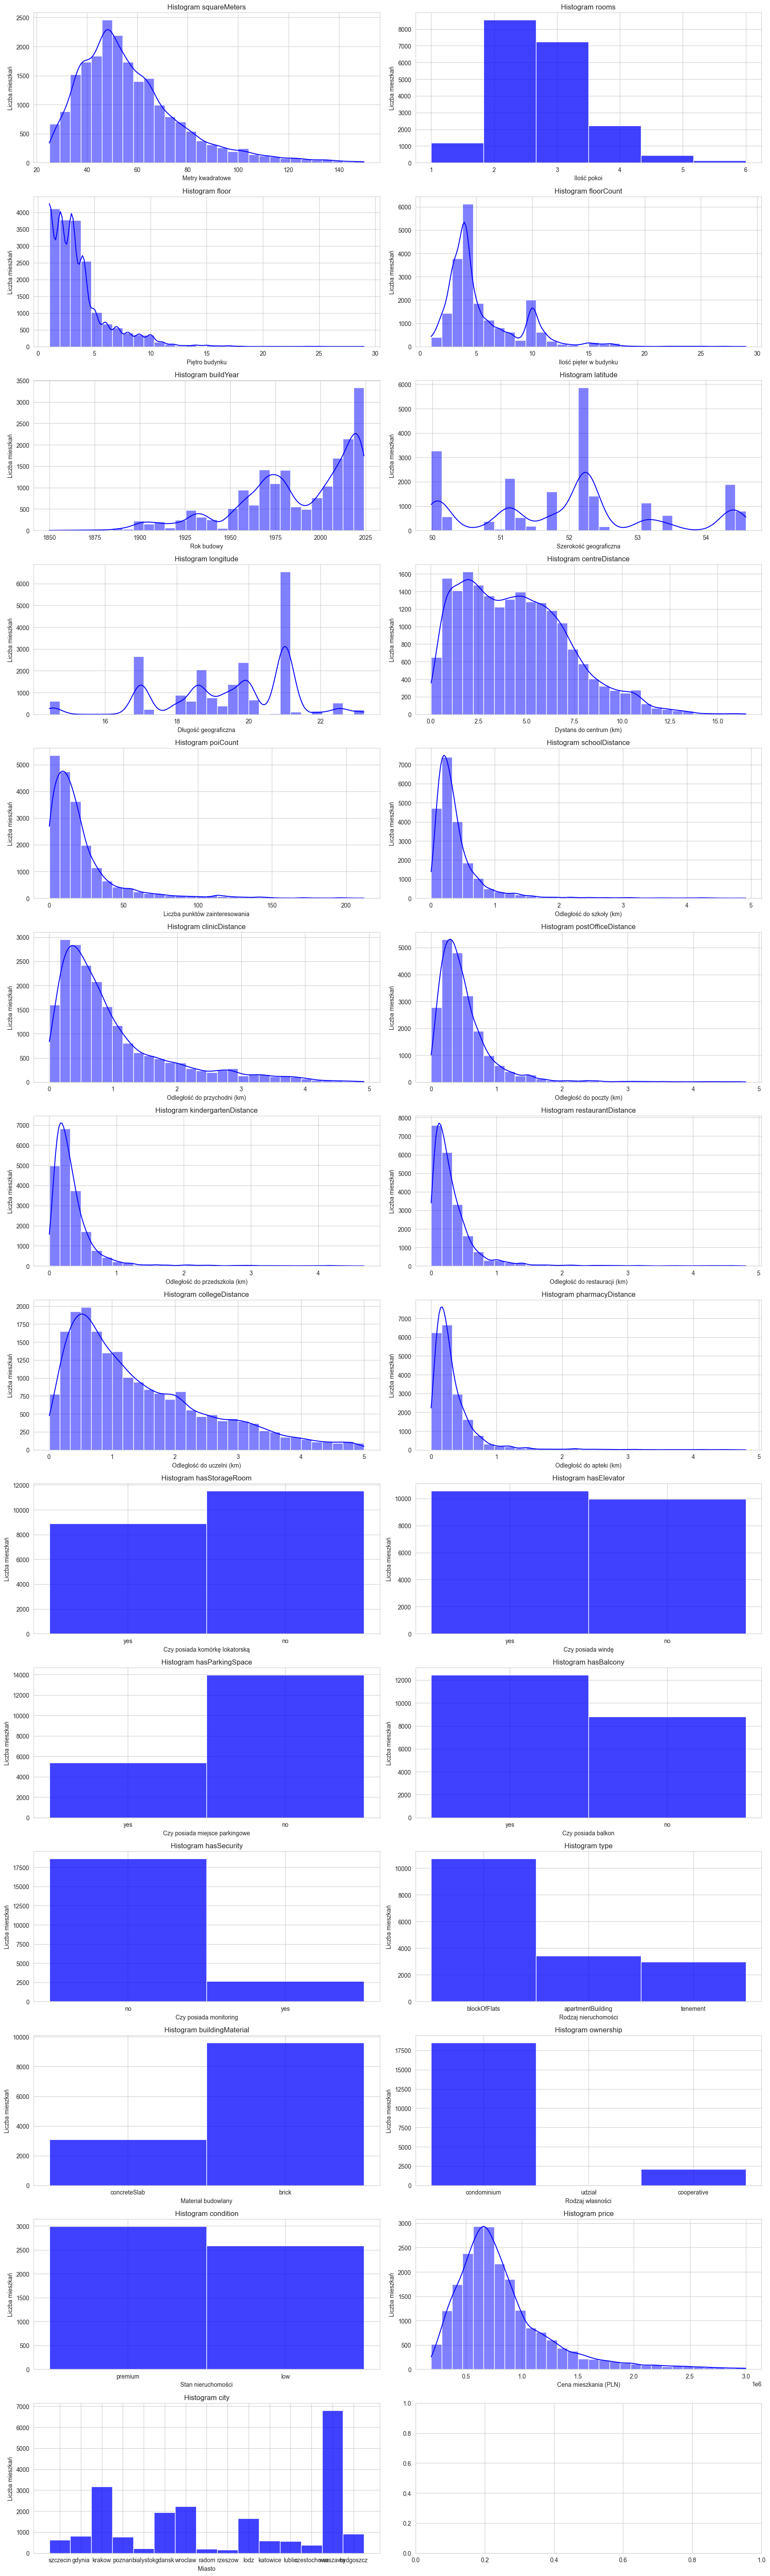

In [37]:
def create_hist_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="blue", bins=30, kde=True):
    sns.histplot(data[column], bins=bins, kde=kde, color=color, ax=axes[index])
    axes[index].set_title(f"Histogram {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)


fig, axes = plt.subplots(14, 2, figsize=(18, 60))
axes = axes.flatten()

create_hist_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_hist_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi", bins=6, kde=False)
create_hist_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_hist_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_hist_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_hist_plot(5, apartments_data, "latitude", axes, xlabel="Szerokość geograficzna")
create_hist_plot(6, apartments_data, "longitude", axes, xlabel="Długość geograficzna")
create_hist_plot(7, apartments_data, "centreDistance", axes, xlabel="Dystans do centrum (km)")
create_hist_plot(8, apartments_data, "poiCount", axes, xlabel="Liczba punktów zainteresowania")
create_hist_plot(9, apartments_data, "schoolDistance", axes, xlabel="Odległość do szkoły (km)")
create_hist_plot(10, apartments_data, "clinicDistance", axes, xlabel="Odległość do przychodni (km)")
create_hist_plot(11, apartments_data, "postOfficeDistance", axes, xlabel="Odległość do poczty (km)")
create_hist_plot(12, apartments_data, "kindergartenDistance", axes, xlabel="Odległość do przedszkola (km)")
create_hist_plot(13, apartments_data, "restaurantDistance", axes, xlabel="Odległość do restauracji (km)")
create_hist_plot(14, apartments_data, "collegeDistance", axes, xlabel="Odległość do uczelni (km)")
create_hist_plot(15, apartments_data, "pharmacyDistance", axes, xlabel="Odległość do apteki (km)")
create_hist_plot(16, apartments_data, "hasStorageRoom", axes, xlabel="Czy posiada komórkę lokatorską", kde=False)
create_hist_plot(17, apartments_data, "hasElevator", axes, xlabel="Czy posiada windę", kde=False)
create_hist_plot(18, apartments_data, "hasParkingSpace", axes, xlabel="Czy posiada miejsce parkingowe", kde=False)
create_hist_plot(19, apartments_data, "hasBalcony", axes, xlabel="Czy posiada balkon", kde=False)
create_hist_plot(20, apartments_data, "hasSecurity", axes, xlabel="Czy posiada monitoring", kde=False)
create_hist_plot(21, apartments_data, "type", axes, xlabel="Rodzaj nieruchomości", kde=False)
create_hist_plot(22, apartments_data, "buildingMaterial", axes, xlabel="Materiał budowlany", kde=False)
create_hist_plot(23, apartments_data, "ownership", axes, xlabel="Rodzaj własności", kde=False)
create_hist_plot(24, apartments_data, "condition", axes, xlabel="Stan nieruchomości", kde=False)
create_hist_plot(25, apartments_data, "price", axes, xlabel="Cena mieszkania (PLN)")
create_hist_plot(26, apartments_data, "city", axes, xlabel="Miasto", kde=False)

plt.tight_layout()
plt.show()

1. Metraż mieszkań - Większość mieszkań na rynku ma powierzchnię między 40 a 70 m², ze średnią wynoszącą około 57 m². Widoczna jest asymetria rozkładu w stronę mniejszych mieszkań.
2. Liczba pokoi - Dominują mieszkania 2 i 3 pokojowe, które stanowią największą część oferty rynkowej.
3. Piętro - Najczęściej spotykane są mieszkania na 1-4 piętrze. 
4. Ilość pięter w budynku - Przeważają budynki 4-piętrowe, choć rozkład jest zróżnicowany.
5. Rok budowy - Zauważalny jest wyraźny dwumodalny rozkład z dwoma szczytami: jeden dla budynków z lat 1970-1980 (okres PRL) i drugi dla nowych inwestycji po 2000 roku
6. Cena - Rozkład cen jest asymetryczny, z przewagą mieszkań w przedziale 500-900k pln.
7. Czy poisada miejsce parkingowe - Większość nieruchmości nie posiada miejsca parkingowego
8. Czy posiada windę - Co druga nieruchomość posiada windę
9. Material budowlany - 70% nieruchomości wykonana jest z cegly, pozostala z betonowej plyty.
10. Rodzaj nieruchomości - Dominują mieszkania w bloku / kamienicy

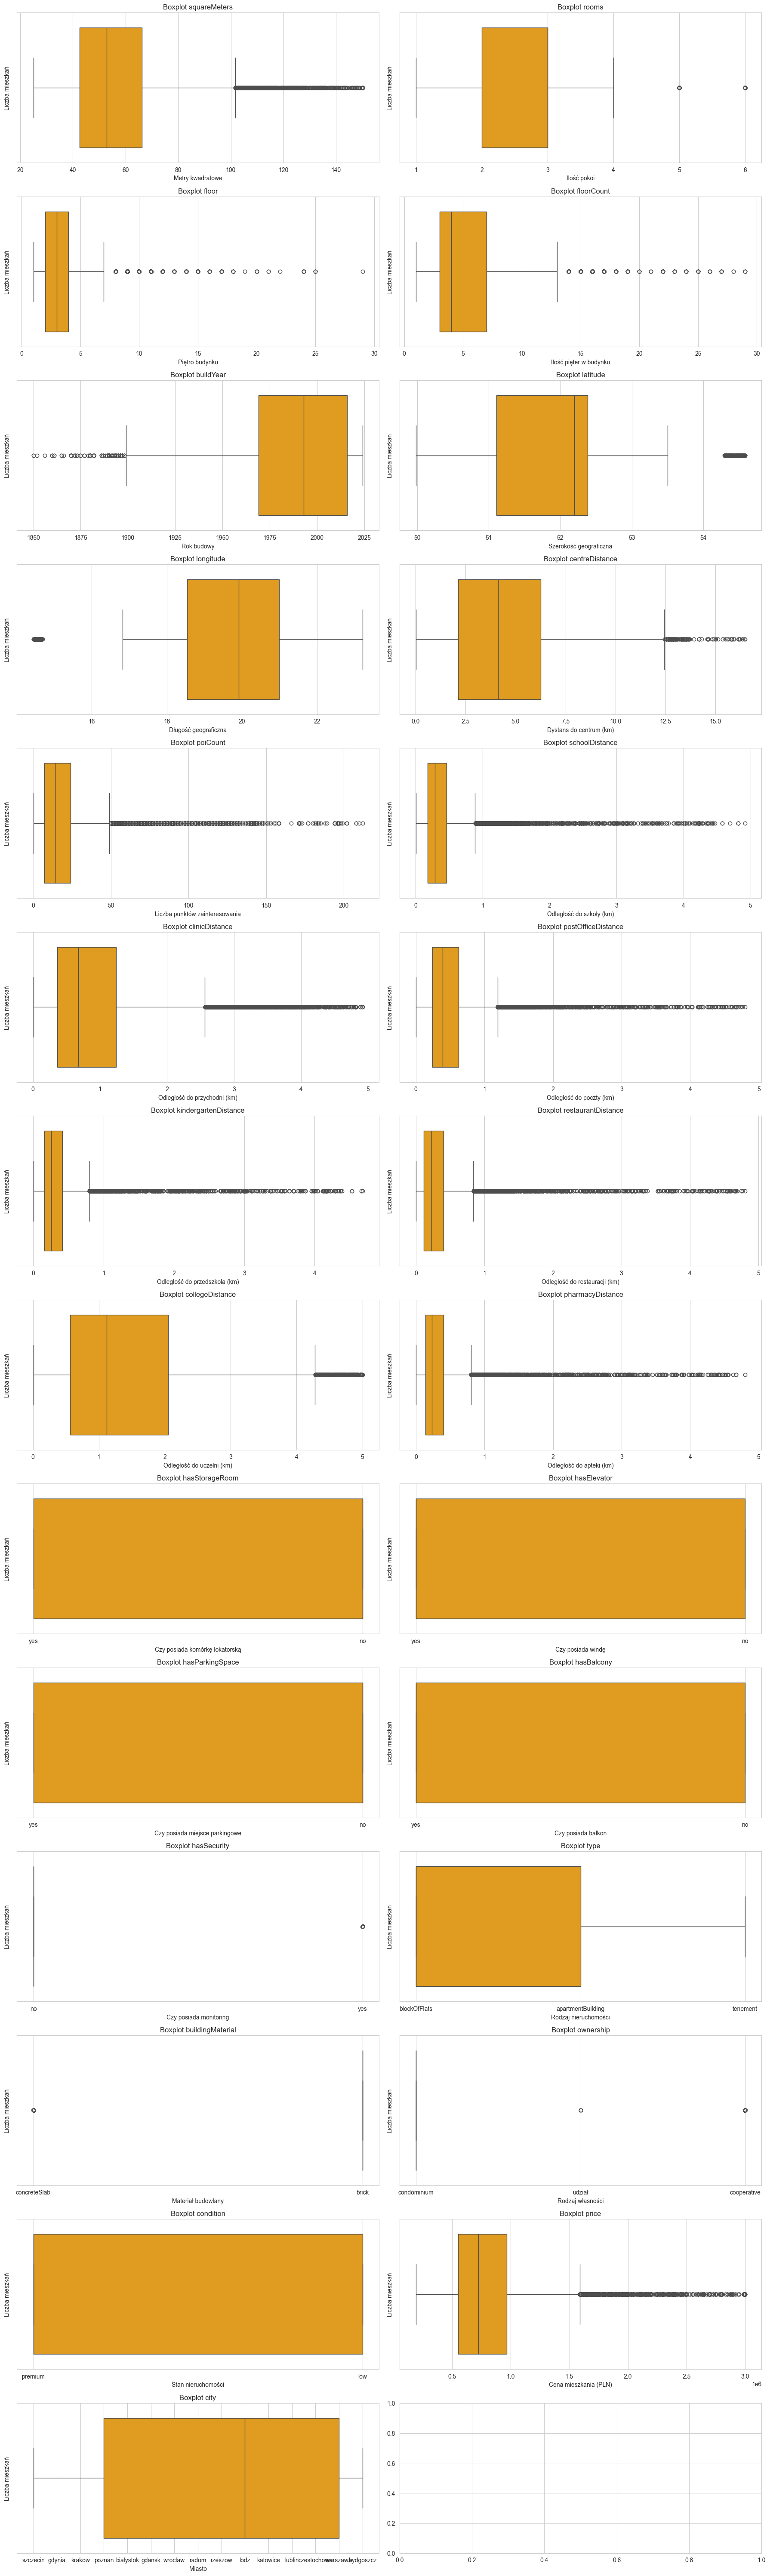

In [38]:
def create_box_plot(index, data, column, axes, xlabel=None, ylabel="Liczba mieszkań", color="orange"):
    sns.boxplot(data[column], color=color, ax=axes[index], orient='h')
    axes[index].set_title(f"Boxplot {column}")
    axes[index].set_xlabel(xlabel)
    axes[index].set_ylabel(ylabel)


fig, axes = plt.subplots(14, 2, figsize=(18, 60))
axes = axes.flatten()

create_box_plot(0, apartments_data, "squareMeters", axes, xlabel="Metry kwadratowe")
create_box_plot(1, apartments_data, "rooms", axes, xlabel="Ilość pokoi")
create_box_plot(2, apartments_data, "floor", axes, xlabel="Piętro budynku")
create_box_plot(3, apartments_data, "floorCount", axes, xlabel="Ilość pięter w budynku")
create_box_plot(4, apartments_data, "buildYear", axes, xlabel="Rok budowy")
create_box_plot(5, apartments_data, "latitude", axes, xlabel="Szerokość geograficzna")
create_box_plot(6, apartments_data, "longitude", axes, xlabel="Długość geograficzna")
create_box_plot(7, apartments_data, "centreDistance", axes, xlabel="Dystans do centrum (km)")
create_box_plot(8, apartments_data, "poiCount", axes, xlabel="Liczba punktów zainteresowania")
create_box_plot(9, apartments_data, "schoolDistance", axes, xlabel="Odległość do szkoły (km)")
create_box_plot(10, apartments_data, "clinicDistance", axes, xlabel="Odległość do przychodni (km)")
create_box_plot(11, apartments_data, "postOfficeDistance", axes, xlabel="Odległość do poczty (km)")
create_box_plot(12, apartments_data, "kindergartenDistance", axes, xlabel="Odległość do przedszkola (km)")
create_box_plot(13, apartments_data, "restaurantDistance", axes, xlabel="Odległość do restauracji (km)")
create_box_plot(14, apartments_data, "collegeDistance", axes, xlabel="Odległość do uczelni (km)")
create_box_plot(15, apartments_data, "pharmacyDistance", axes, xlabel="Odległość do apteki (km)")
create_box_plot(16, apartments_data, "hasStorageRoom", axes, xlabel="Czy posiada komórkę lokatorską")
create_box_plot(17, apartments_data, "hasElevator", axes, xlabel="Czy posiada windę")
create_box_plot(18, apartments_data, "hasParkingSpace", axes, xlabel="Czy posiada miejsce parkingowe")
create_box_plot(19, apartments_data, "hasBalcony", axes, xlabel="Czy posiada balkon")
create_box_plot(20, apartments_data, "hasSecurity", axes, xlabel="Czy posiada monitoring")
create_box_plot(21, apartments_data, "type", axes, xlabel="Rodzaj nieruchomości")
create_box_plot(22, apartments_data, "buildingMaterial", axes, xlabel="Materiał budowlany")
create_box_plot(23, apartments_data, "ownership", axes, xlabel="Rodzaj własności")
create_box_plot(24, apartments_data, "condition", axes, xlabel="Stan nieruchomości")
create_box_plot(25, apartments_data, "price", axes, xlabel="Cena mieszkania (PLN)")
create_box_plot(26, apartments_data, "city", axes, xlabel="Miasto")

plt.tight_layout()
plt.show()



Wnioski z owych wykresów są tożsame z tymi spod histogramów.

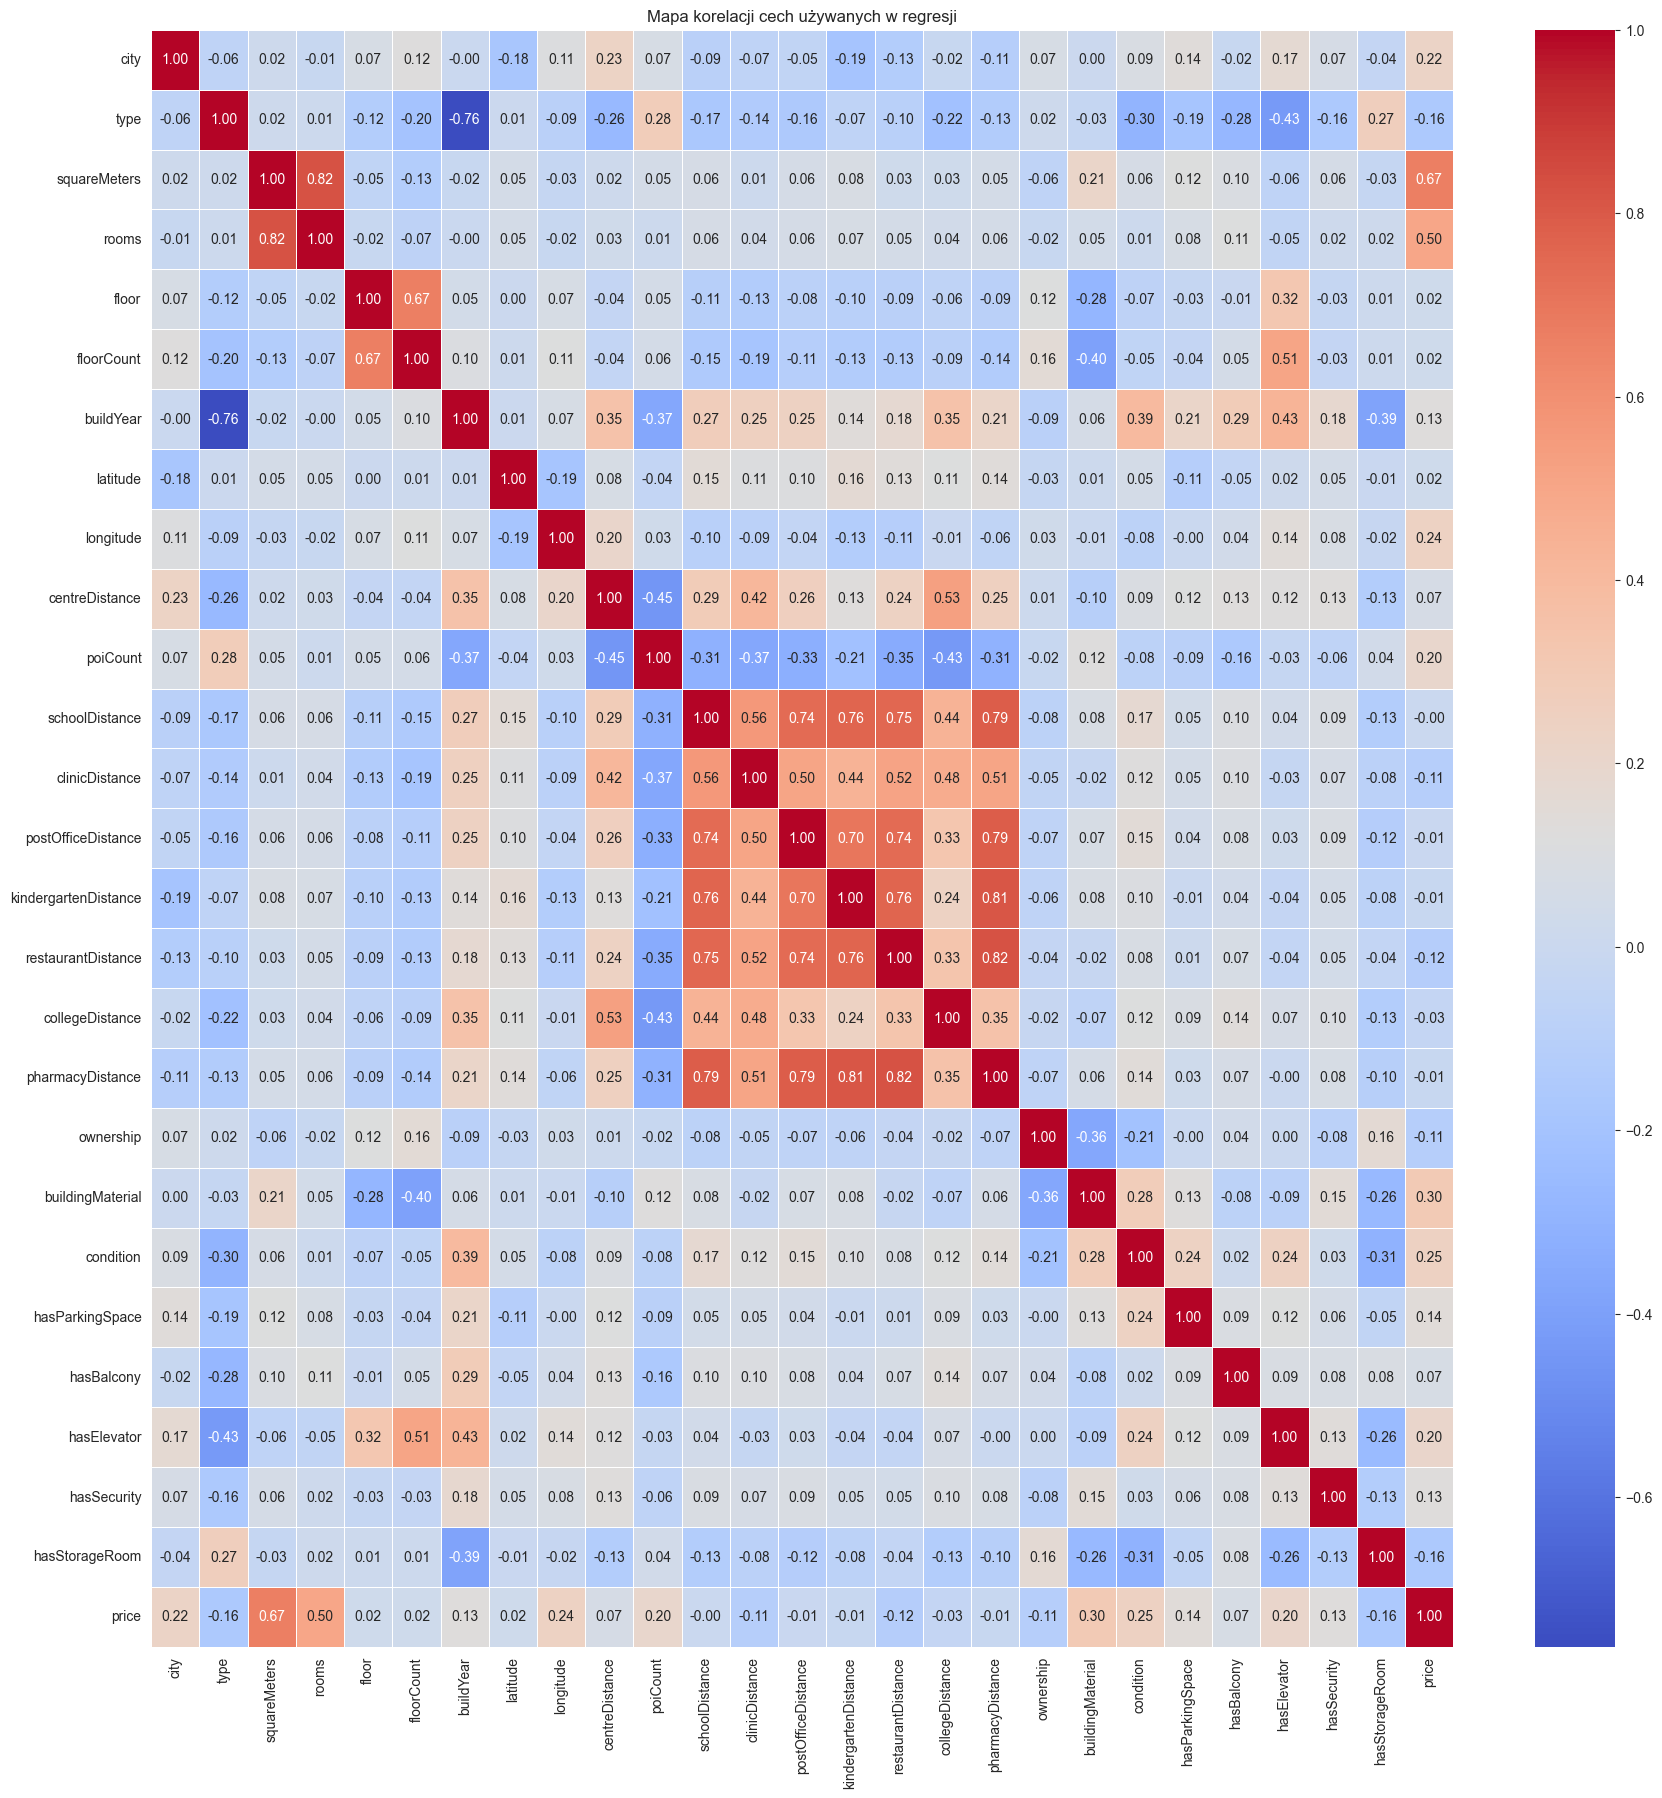

In [39]:
filtered_data = apartments_data[selected_columns].copy()

filtered_data["hasElevator"] = filtered_data["hasElevator"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasParkingSpace"] = filtered_data["hasParkingSpace"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["type"] = filtered_data["type"].map({"blockOfFlats": 1, "apartmentBuilding": 0, "tenement": 2}).astype(
    "Int64")
filtered_data["hasStorageRoom"] = filtered_data["hasStorageRoom"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["buildingMaterial"] = filtered_data["buildingMaterial"].map({"brick": 1, "concreteSlab": 0}).astype(
    "Int64")
filtered_data["hasBalcony"] = filtered_data["hasBalcony"].map({"yes": 1, "no": 0}).astype("Int64")
filtered_data["hasSecurity"] = filtered_data["hasSecurity"].map({"yes": 1, "no": 0}).astype("Int64")

filtered_data["ownership"] = filtered_data["ownership"].map({
    "condominium": 0,
    "cooperative": 1,
    "udział": 2
}).astype("Int64")

filtered_data["condition"] = filtered_data["condition"].map({
    "low": 0,
    "premium": 1
}).astype("Int64")

filtered_data["city"] = filtered_data["city"].astype("category").cat.codes

corr_matrix = filtered_data.corr(method='pearson')

plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

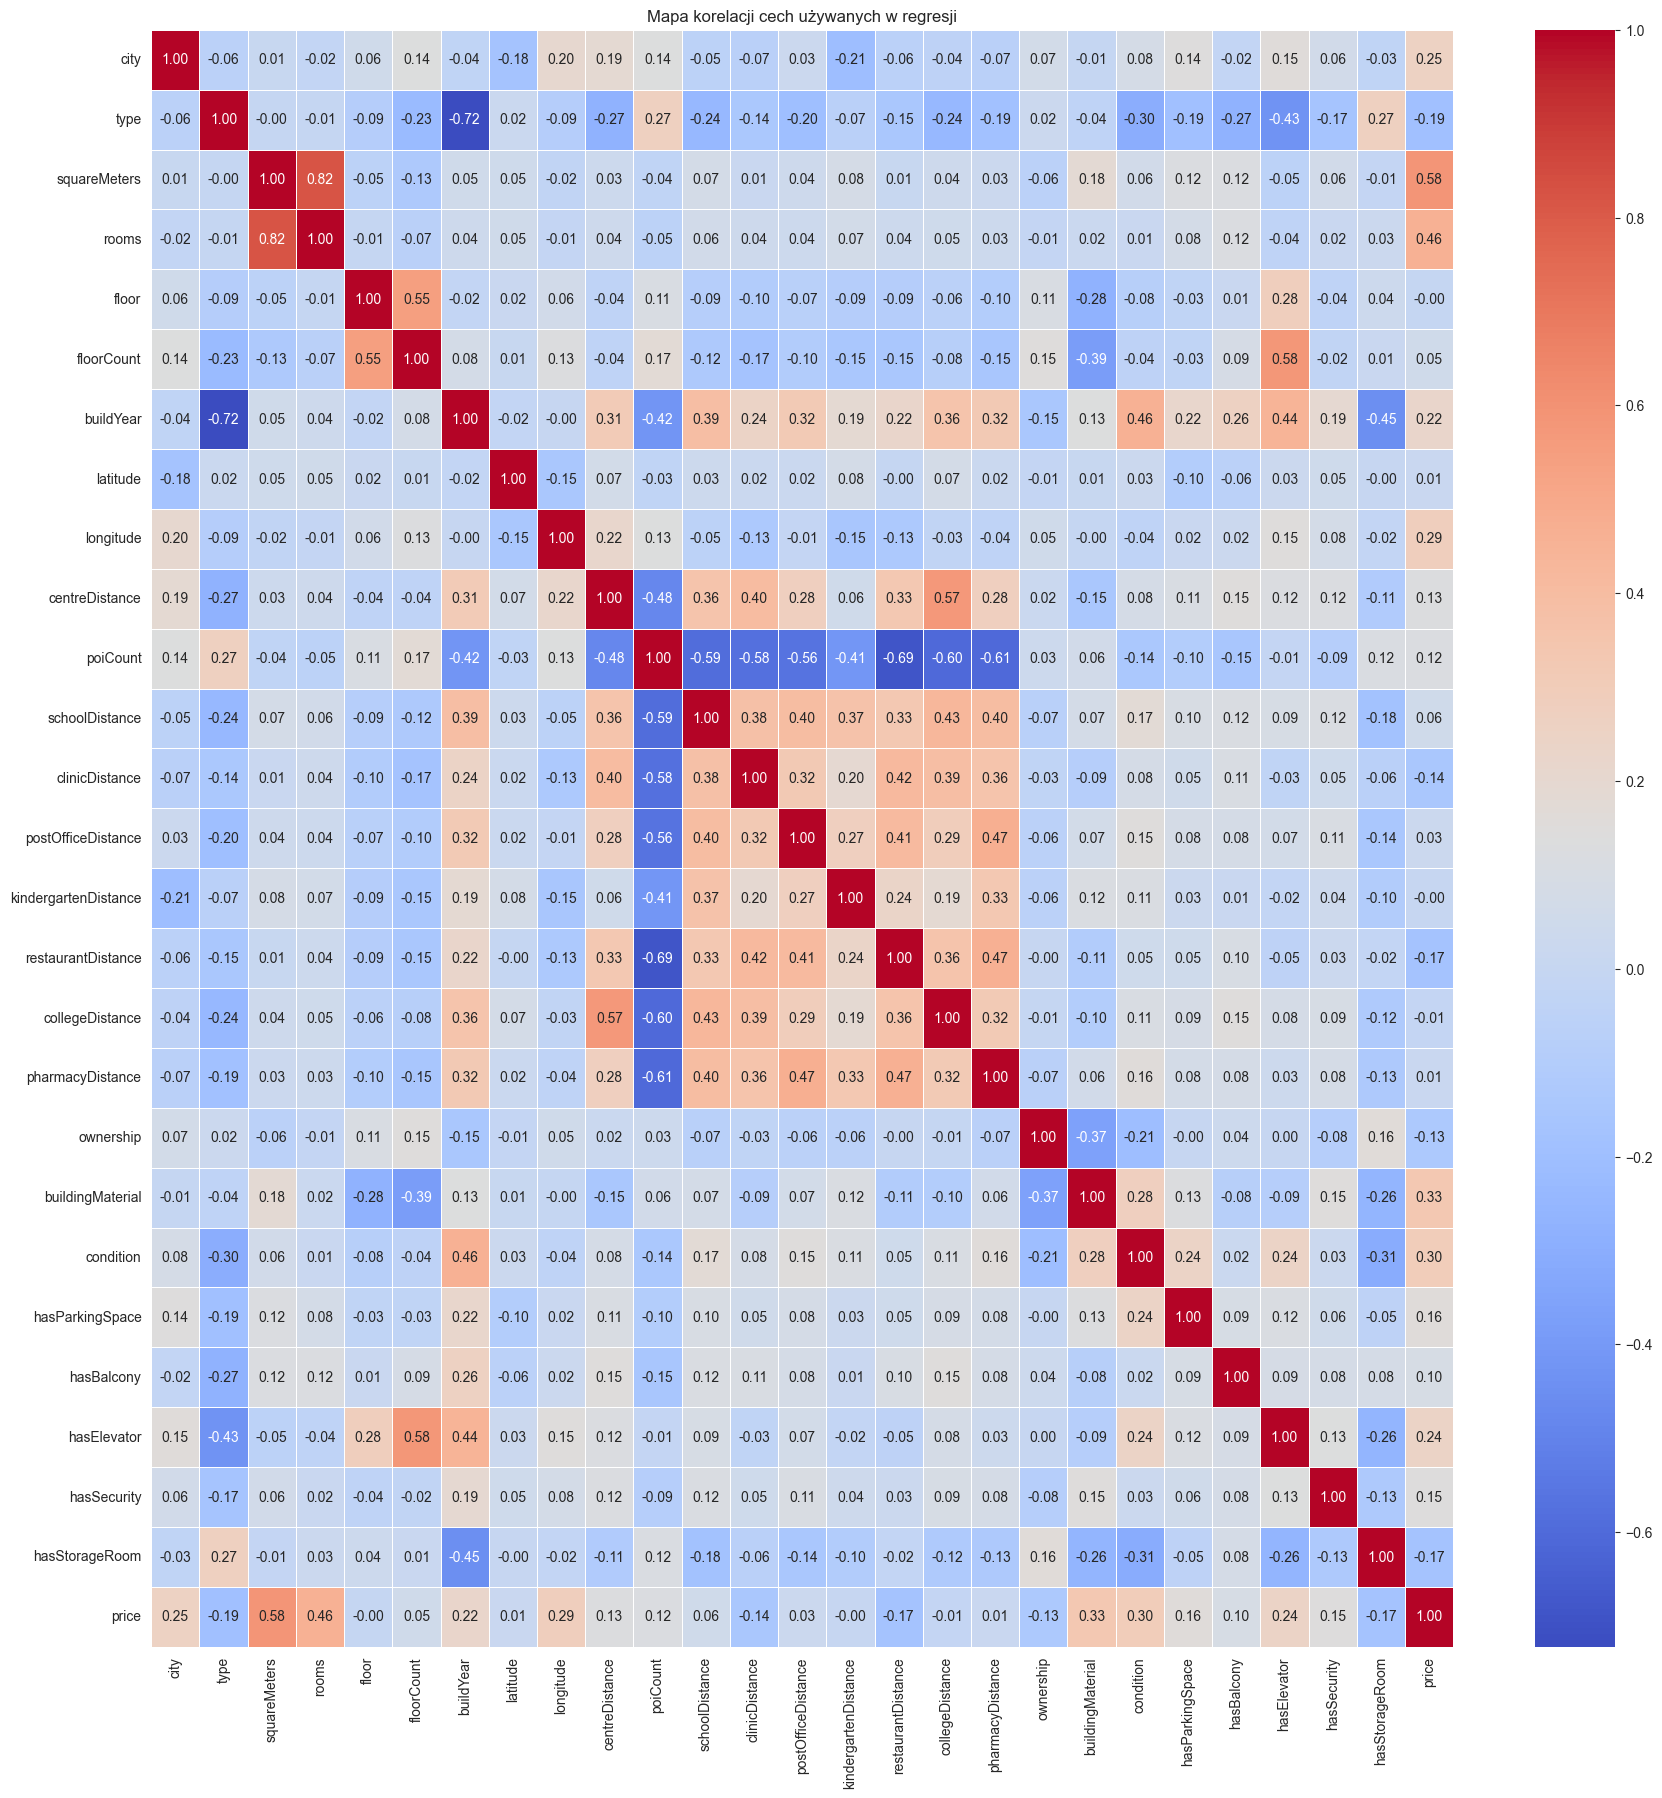

In [40]:
corr_matrix = filtered_data.corr(method='spearman')

plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa korelacji cech używanych w regresji")
plt.show()

Wnioski:
1. Metraż i liczba pokoi - Najsilniejsza korelacja w obu metodach (Pearson: 0.82, Spearman: 0.82)
   - Zależność ta jest oczywista i potwierdza, że większe mieszkania posiadają więcej pokoi.

2. Metraż i cena - Bardzo silna korelacja (Pearson: 0.67, Spearman: 0.59)
   - Potwierdza, że powierzchnia mieszkania jest kluczowym czynnikiem wpływającym na jego cenę.

3. Liczba pięter w budynku i obecność windy - Silna korelacja (Pearson: 0.51, Spearman: 0.58)
   - Im wyższy budynek, tym większe prawdopodobieństwo, że posiada windę.

4. Piętro i liczba pięter w budynku - Silna korelacja (Pearson: 0.67, Spearman: 0.55)
   - Mieszkania na wyższych piętrach znajdują się częściej w wyższych budynkach.

5. Rok budowy i obecność windy - Wyraźna korelacja (Pearson: 0.43, Spearman: 0.44)
   - Nowsze budynki częściej wyposażone są w windy.

6. Liczba pokoi i cena - Znacząca korelacja (Pearson: 0.50, Spearman: 0.46)
   - Potwierdza wpływ liczby pokoi na cenę mieszkania.


In [41]:
avg_prices = apartments_data[['city', 'price']].copy().groupby('city')['price'].agg(['mean', 'count']).reset_index()

avg_prices.columns = ['City', 'Average Price', 'Number of properties']

avg_prices['Average Price'] = avg_prices['Average Price'].round(0).astype(int)

avg_prices = avg_prices.sort_values('Average Price', ascending=False)
avg_prices

,City,Average Price,Number of properties
13,warszawa,1054201,6812
6,krakow,942544,3173
3,gdansk,891934,1947
4,gdynia,881991,813
14,wroclaw,745087,2232
9,poznan,647823,778
11,rzeszow,638386,158
8,lublin,581281,567
12,szczecin,573594,638
5,katowice,528615,582


Jak można zauważyć na powyższym zestawieniu najwyższa średnia cena transakcyjna występuje w stolicy polski i wynosi: 1,053,134 pln. Na drugim miejscu plasuje się Kraków z średnią ceną niższą o 110 tys. pln niż Warszawa tj. 942,169 pln

In [42]:
import folium
from folium.plugins import HeatMap

cracow_df = apartments_data[apartments_data['city'] == 'krakow'].copy()
cracow_df = cracow_df.dropna(subset=['latitude', 'longitude'])

center_lat = cracow_df['latitude'].mean()
center_lng = cracow_df['longitude'].mean()

points = cracow_df[['latitude', 'longitude']].values.tolist()

cracow_map = folium.Map(location=[center_lat, center_lng], zoom_start=12)

HeatMap(points).add_to(cracow_map)

cracow_map

Mapa cieplna przedstawia geograficzny rozkład ofert nieruchomości w Krakowie, ukazując ich koncentrację w poszczególnych częściach miasta. Najwyższa gęstość ofert znajduje się w centrum, co wskazuje na duże zapotrzebowanie na nieruchomości w tej lokalizacji. Dzielnice takie jak Stare Miasto i Kazimierz cieszą się szczególną popularnością. Mniejsza liczba ofert na obrzeżach Krakowa wskazuje na niższe zainteresowanie lub ograniczoną podaż w tych rejonach.

### Wypelnienie KNN

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

knn_data = apartments_data.copy()
knn_data = knn_data.replace({None: np.nan, 'None': np.nan})

cat_cols = knn_data.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = knn_data.select_dtypes(include=['number']).columns.tolist()

encoders = {}
impute_knn_data = knn_data.copy()

for col in cat_cols:
    le = LabelEncoder()

    non_null_values = knn_data[col].dropna().astype(str).values
    le.fit(non_null_values)

    impute_knn_data.loc[knn_data[col].notna(), col] = le.transform(knn_data.loc[knn_data[col].notna(), col].astype(str))
    encoders[col] = le

knn = KNNImputer(n_neighbors=5)
imputed_values = knn.fit_transform(impute_knn_data)

knn_data = pd.DataFrame(imputed_values, columns=knn_data.columns)

for col in cat_cols:
    le = encoders[col]
    knn_data[col] = np.round(knn_data[col]).astype(int)
    knn_data[col] = np.clip(knn_data[col], 0, len(le.classes_) - 1)
    knn_data[col] = le.inverse_transform(knn_data[col].astype(int))

knn_data[cat_cols] = knn_data[cat_cols].astype('category')

knn_data

,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,szczecin,blockOfFlats,47.00,2.0,6.0,12.0,1981.0,53.428544,14.552812,0.790,67.0,0.288,0.285,0.2680,0.2450,0.0680,0.593,0.1524,condominium,concreteSlab,premium,no,yes,yes,no,yes,449000.0
1,szczecin,apartmentBuilding,88.22,3.0,1.0,2.0,2000.0,53.449093,14.516844,4.090,0.0,0.509,1.039,0.9980,0.6760,0.6610,1.192,0.6680,condominium,brick,premium,yes,yes,no,no,no,950000.0
2,szczecin,apartmentBuilding,117.00,5.0,4.0,4.0,1989.4,53.443096,14.561348,3.686,10.0,0.216,0.611,0.7430,0.3236,0.2980,1.522,0.2290,udział,brick,premium,yes,yes,no,no,no,1099000.0
3,szczecin,blockOfFlats,33.31,1.0,1.0,4.0,1963.0,53.436100,14.541200,1.930,39.0,0.073,0.326,0.2892,0.0890,0.2462,0.041,0.3880,cooperative,brick,low,yes,no,no,yes,yes,380000.0
4,szczecin,blockOfFlats,56.00,3.0,7.0,7.0,2018.0,53.447465,14.557811,4.502,10.0,0.268,0.771,0.6760,0.2600,0.3220,1.643,0.1780,condominium,brick,premium,no,yes,yes,yes,yes,799000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21496,bydgoszcz,blockOfFlats,54.00,2.4,4.0,4.0,1982.2,53.126520,18.045220,3.010,16.0,0.325,0.599,0.2010,0.2160,0.1110,0.614,0.0620,condominium,concreteSlab,premium,no,yes,no,no,no,460000.0
21497,bydgoszcz,tenement,98.00,3.0,2.2,2.0,1925.0,53.124655,18.008459,0.590,49.0,0.113,0.226,0.2250,0.4120,0.1240,0.478,0.2730,condominium,brick,low,no,no,no,no,yes,499000.0
21498,bydgoszcz,tenement,108.96,5.0,2.0,4.0,1889.0,53.131748,18.000648,1.080,28.0,0.281,0.792,0.2330,1.0928,0.1070,0.226,0.1430,condominium,brick,low,no,no,no,no,yes,795000.0
21499,bydgoszcz,blockOfFlats,50.12,2.0,1.0,1.0,1953.4,53.129657,18.003888,0.880,42.0,0.174,0.496,0.3880,0.4600,0.0790,0.332,0.2500,condominium,brick,low,yes,no,no,no,no,360000.0


### Wypelnienie średnią wartością

In [44]:
mean_data = apartments_data.copy()
mean_data = mean_data.replace({None: np.nan, 'None': np.nan})

cat_cols = mean_data.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = mean_data.select_dtypes(include=['number']).columns.tolist()

for col in numeric_cols:
    mean_value = mean_data[col].mean()
    mean_data[col].fillna(mean_value, inplace=True)

for col in cat_cols:
    mode_value = mean_data[col].mode()[0]
    mean_data[col].fillna(mode_value, inplace=True)

mean_data[cat_cols] = mean_data[cat_cols].astype('category')

mean_data

/var/folders/3d/q2hrtkpd4n9d2g8ry1gh3j940000gn/T/ipykernel_95391/2630931095.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mean_data[col].fillna(mean_value, inplace=True)
/var/folders/3d/q2hrtkpd4n9d2g8ry1gh3j940000gn/T/ipykernel_95391/2630931095.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,szczecin,blockOfFlats,47.00,2.000000,6.000000,12.0,1981.000000,53.428544,14.552812,0.790000,67.0,0.288,0.285,0.268000,0.245000,0.068000,0.593,0.347931,condominium,concreteSlab,premium,no,yes,yes,no,yes,449000
1,szczecin,apartmentBuilding,88.22,3.000000,1.000000,2.0,2000.000000,53.449093,14.516844,4.090000,0.0,0.509,1.039,0.998000,0.676000,0.661000,1.192,0.668000,condominium,brick,premium,yes,yes,no,no,no,950000
2,szczecin,apartmentBuilding,117.00,5.000000,4.000000,4.0,1986.774129,53.443096,14.561348,4.434692,10.0,0.216,0.611,0.743000,0.357316,0.298000,1.522,0.229000,udział,brick,premium,yes,yes,no,no,no,1099000
3,szczecin,blockOfFlats,33.31,1.000000,1.000000,4.0,1963.000000,53.436100,14.541200,1.930000,39.0,0.073,0.326,0.510092,0.089000,0.335955,0.041,0.388000,cooperative,brick,premium,yes,no,no,yes,yes,380000
4,szczecin,blockOfFlats,56.00,3.000000,7.000000,7.0,2018.000000,53.447465,14.557811,4.434692,10.0,0.268,0.771,0.676000,0.260000,0.322000,1.643,0.178000,condominium,brick,premium,no,yes,yes,yes,yes,799000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21496,bydgoszcz,blockOfFlats,54.00,2.624842,4.000000,4.0,1986.774129,53.126520,18.045220,3.010000,16.0,0.325,0.599,0.201000,0.216000,0.111000,0.614,0.062000,condominium,brick,premium,no,yes,no,no,no,460000
21497,bydgoszcz,tenement,98.00,3.000000,3.404786,2.0,1925.000000,53.124655,18.008459,0.590000,49.0,0.113,0.226,0.225000,0.412000,0.124000,0.478,0.273000,condominium,brick,premium,no,no,no,no,yes,499000
21498,bydgoszcz,tenement,108.96,5.000000,2.000000,4.0,1889.000000,53.131748,18.000648,1.080000,28.0,0.281,0.792,0.233000,0.357316,0.107000,0.226,0.143000,condominium,brick,premium,no,no,no,no,yes,795000
21499,bydgoszcz,blockOfFlats,50.12,2.000000,1.000000,1.0,1986.774129,53.129657,18.003888,0.880000,42.0,0.174,0.496,0.388000,0.460000,0.079000,0.332,0.250000,condominium,brick,premium,yes,no,no,no,no,360000


### Wypelnienie losową wartością

In [45]:
random_data = apartments_data.copy()
random_data = random_data.replace({None: np.nan, 'None': np.nan})

cat_cols = random_data.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = random_data.select_dtypes(include=['number']).columns.tolist()

for col in numeric_cols:
    valid_values = random_data.loc[random_data[col].notna(), col].values

    missing_indices = random_data[col].isna()

    if sum(missing_indices) > 0 and len(valid_values) > 0:
        random_fills = np.random.choice(valid_values, size=sum(missing_indices))
        random_data.loc[missing_indices, col] = random_fills

for col in cat_cols:
    valid_values = random_data.loc[random_data[col].notna(), col].values

    missing_indices = random_data[col].isna()

    if sum(missing_indices) > 0 and len(valid_values) > 0:
        random_fills = np.random.choice(valid_values, size=sum(missing_indices))
        random_data.loc[missing_indices, col] = random_fills

random_data[cat_cols] = random_data[cat_cols].astype('category')

random_data

,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,szczecin,blockOfFlats,47.00,2.0,6.0,12.0,1981.0,53.428544,14.552812,0.79,67.0,0.288,0.285,0.268,0.245,0.068,0.593,0.225,condominium,concreteSlab,premium,no,yes,yes,no,yes,449000
1,szczecin,apartmentBuilding,88.22,3.0,1.0,2.0,2000.0,53.449093,14.516844,4.09,0.0,0.509,1.039,0.998,0.676,0.661,1.192,0.668,condominium,brick,premium,yes,yes,no,no,no,950000
2,szczecin,apartmentBuilding,117.00,5.0,4.0,4.0,2024.0,53.443096,14.561348,0.88,10.0,0.216,0.611,0.743,0.264,0.298,1.522,0.229,udział,brick,premium,yes,yes,no,no,no,1099000
3,szczecin,blockOfFlats,33.31,1.0,1.0,4.0,1963.0,53.436100,14.541200,1.93,39.0,0.073,0.326,0.176,0.089,1.353,0.041,0.388,cooperative,brick,premium,yes,no,no,yes,yes,380000
4,szczecin,blockOfFlats,56.00,3.0,7.0,7.0,2018.0,53.447465,14.557811,5.86,10.0,0.268,0.771,0.676,0.260,0.322,1.643,0.178,condominium,brick,premium,no,yes,yes,yes,yes,799000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21496,bydgoszcz,blockOfFlats,54.00,3.0,4.0,4.0,2016.0,53.126520,18.045220,3.01,16.0,0.325,0.599,0.201,0.216,0.111,0.614,0.062,condominium,brick,low,no,yes,no,no,no,460000
21497,bydgoszcz,tenement,98.00,3.0,3.0,2.0,1925.0,53.124655,18.008459,0.59,49.0,0.113,0.226,0.225,0.412,0.124,0.478,0.273,condominium,brick,premium,no,no,no,no,yes,499000
21498,bydgoszcz,tenement,108.96,5.0,2.0,4.0,1889.0,53.131748,18.000648,1.08,28.0,0.281,0.792,0.233,0.177,0.107,0.226,0.143,condominium,brick,premium,no,no,no,no,yes,795000
21499,bydgoszcz,blockOfFlats,50.12,2.0,1.0,1.0,2017.0,53.129657,18.003888,0.88,42.0,0.174,0.496,0.388,0.460,0.079,0.332,0.250,condominium,brick,premium,yes,no,no,no,no,360000


### Podzial na zbiór treningowy i testowy

In [46]:
X = apartments_data.iloc[:, :-1]
Y = apartments_data.iloc[:, -1]

In [47]:
def split_set_into_training(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        training_size_percentage: float,
        random_state: int = 2137
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    X_shuffled = X.sample(frac=1.0, random_state=random_state)
    Y_shuffled = Y.reindex(X_shuffled.index)

    n_train = int(training_size_percentage * len(X_shuffled))

    X_train = X_shuffled.iloc[:n_train]
    Y_train = Y_shuffled.iloc[:n_train]
    X_test = X_shuffled.iloc[n_train:]
    Y_test = Y_shuffled.iloc[n_train:]

    return X_train, Y_train, X_test, Y_test


In [66]:
def split_set_into_cross_validation(X: pd.DataFrame, Y: pd.DataFrame, n_splits: int = 5, random_state: int = 2137) -> \
        tuple[
            pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    indices = pd.Series(X.index).sample(frac=1.0, random_state=random_state).tolist()
    n_samples = len(indices)
    fold_sizes = [n_samples // n_splits + (1 if i < n_samples % n_splits else 0) for i in range(n_splits)]

    folds = []
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = indices[:start] + indices[stop:]

        X_train = X.loc[train_idx]
        Y_train = Y.loc[train_idx]
        X_test = X.loc[test_idx]
        Y_test = Y.loc[test_idx]

        folds.append((X_train, Y_train, X_test, Y_test))
        current = stop

    return folds


folds = split_set_into_cross_validation(X, Y, n_splits=5, random_state=42)
X_train, Y_train, X_test, Y_test = folds[1]
X_train_2, _, _, _ = folds[0]
print("X_train size: ", X_train.shape[0])
print("Y_train size: ", Y_train.shape[0])
print("X_test size: ", X_test.shape[0])
print("Y_Test size: ", Y_test.shape[0])
print(f'size of X: {X.shape[0]}')
print(f'size of Y: {Y.shape[0]}')

print(np.array_equal(X_train, X_train_2))

X_train size:  17201
Y_train size:  17201
X_test size:  4300
Y_Test size:  4300
size of X: 21501
size of Y: 21501
False


### Skalowanie minmax i standaryzacja

In [50]:
def apply_standard_scaling(X):
    scaled_df = X.copy()
    numeric_cols = X.select_dtypes(include=['number']).columns
    scaling_params = {}

    for col in numeric_cols:
        mean_val = X[col].mean()
        std_val = X[col].std()

        if std_val == 0:
            scaled_df[col] = 0
        else:
            scaled_df[col] = (X[col] - mean_val) / std_val

        scaling_params[col] = {'mean': mean_val, 'std': std_val}

    return scaled_df, scaling_params


def apply_minmax_scaling(X):
    scaled_X = X.copy()
    numeric_cols = X.select_dtypes(include=['number']).columns
    scaling_params = {}

    for col in numeric_cols:
        min_val = X[col].min()
        max_val = X[col].max()

        if max_val == min_val:
            scaled_X[col] = 0.5
        else:
            scaled_X[col] = (X[col] - min_val) / (max_val - min_val)

        scaling_params[col] = {'min': min_val, 'max': max_val}

    return scaled_X, scaling_params

### Wszystkie zbiory danych

In [51]:
knn_features = knn_data.copy().iloc[:, :-1]
knn_target = knn_data.copy().iloc[:, -1]

# knn min-max
knn_minmax_features, knn_minmax_params = apply_minmax_scaling(knn_features)

# knn standardized
knn_standardize_features, knn_standardize_params = apply_standard_scaling(knn_features)

In [52]:
mean_features = mean_data.copy().iloc[:, :-1]
mean_target = mean_data.copy().iloc[:, -1]

# mean min-max
mean_minmax_features, mean_minmax_params = apply_minmax_scaling(mean_features)

# mean standardized
mean_standardize_features, mean_standardize_params = apply_standard_scaling(mean_features)

In [53]:
random_features = random_data.copy().iloc[:, :-1]
random_target = random_data.copy().iloc[:, -1]

# random min-max
random_minmax_features, random_minmax_params = apply_minmax_scaling(random_features)

# random standardized
random_standardize_features, random_standardize_params = apply_standard_scaling(random_features)

### Trenowanie modeli

In [54]:
def root_mean_squared_error(model, X, y) -> float:
    predictions = model.predict(X)
    predictions = np.asarray(predictions).ravel()
    y_true = np.asarray(y).ravel()
    return np.sqrt(((predictions - y_true) ** 2).mean())


### XGBoost

In [55]:
def train_xgboost(X: pd.DataFrame, y: pd.DataFrame) -> float:
    xgb = XGBRegressor(
        use_label_encoder=True,
        enable_categorical=True,
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=2137
    )
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)
    xgb.fit(x_train, y_train)

    return root_mean_squared_error(xgb, x_test, y_test)


knn_minmax_rmse = train_xgboost(knn_minmax_features, knn_target)
knn_standardize_rmse = train_xgboost(knn_standardize_features, knn_target)
mean_minmax_rmse = train_xgboost(mean_minmax_features, knn_target)
mean_standardize_rmse = train_xgboost(mean_standardize_features, knn_target)
random_minmax_rmse = train_xgboost(random_minmax_features, knn_target)
random_standardize_rmse = train_xgboost(random_standardize_features, knn_target)

xgb_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


/Users/lisa/pythonProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:13:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lisa/pythonProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:13:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lisa/pythonProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:13:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/lisa/pythonProject/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:13:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

### CatBoost

In [56]:
def train_catboost(X: pd.DataFrame, y: pd.DataFrame) -> float:
    catboost = CatBoostRegressor(
        eval_metric='RMSE',
        random_seed=2137,
        verbose=100
    )

    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)
    cat_features = X.select_dtypes(include=['category']).columns.tolist()
    catboost.fit(x_train, y_train, cat_features=cat_features)

    return root_mean_squared_error(catboost, x_test, y_test)


knn_minmax_rmse = train_catboost(knn_minmax_features, knn_target)
knn_standardize_rmse = train_catboost(knn_standardize_features, knn_target)
mean_minmax_rmse = train_catboost(mean_minmax_features, mean_target)
mean_standardize_rmse = train_catboost(mean_standardize_features, mean_target)
random_minmax_rmse = train_catboost(random_minmax_features, random_target)
random_standardize_rmse = train_catboost(random_standardize_features, random_target)

catboost_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


Learning rate set to 0.064179
0:	learn: 411928.8900078	total: 65ms	remaining: 1m 4s
100:	learn: 149512.8428358	total: 579ms	remaining: 5.16s
200:	learn: 137176.6487444	total: 1.26s	remaining: 5.02s
300:	learn: 128698.8799058	total: 1.88s	remaining: 4.37s
400:	learn: 121674.0579351	total: 2.37s	remaining: 3.55s
500:	learn: 116080.5870922	total: 2.85s	remaining: 2.84s
600:	learn: 111596.1642017	total: 3.31s	remaining: 2.2s
700:	learn: 107546.4337120	total: 3.77s	remaining: 1.61s
800:	learn: 103905.9322530	total: 4.22s	remaining: 1.05s
900:	learn: 100785.8622653	total: 4.68s	remaining: 514ms
999:	learn: 97791.9476754	total: 5.13s	remaining: 0us
Learning rate set to 0.064179
0:	learn: 411928.8900078	total: 4.46ms	remaining: 4.46s
100:	learn: 149512.8428358	total: 586ms	remaining: 5.21s
200:	learn: 137176.6487444	total: 1.07s	remaining: 4.24s
300:	learn: 128698.8799058	total: 1.52s	remaining: 3.52s
400:	learn: 121674.0579351	total: 1.96s	remaining: 2.93s
500:	learn: 116080.5870922	total: 2.

### Random Forest

In [57]:
from sklearn.ensemble import RandomForestRegressor


def train_random_forest(X: pd.DataFrame, y: pd.DataFrame) -> float:
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)

    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')
    preprocessor.fit(x_train, y_train)

    random_forrest = RandomForestRegressor(
        n_estimators=10,
        max_depth=4,
        random_state=2137
    )

    X_train_enc = preprocessor.transform(x_train)
    random_forrest.fit(X_train_enc, y_train)

    X_test_enc = preprocessor.transform(x_test)
    return root_mean_squared_error(random_forrest, X_test_enc, y_test)


knn_minmax_rmse = train_random_forest(knn_minmax_features, knn_target)
knn_standardize_rmse = train_random_forest(knn_standardize_features, knn_target)
mean_minmax_rmse = train_random_forest(mean_minmax_features, mean_target)
mean_standardize_rmse = train_random_forest(mean_standardize_features, mean_target)
random_minmax_rmse = train_random_forest(random_minmax_features, random_target)
random_standardize_rmse = train_random_forest(random_standardize_features, random_target)

random_forest_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


### NuSVR

In [58]:
from sklearn.svm import NuSVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer


def train_nusvr(X: pd.DataFrame, y: pd.DataFrame) -> float:
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)

    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')
    preprocessor.fit(x_train, y_train)

    nusvr = NuSVR()

    X_train_enc = preprocessor.transform(x_train)
    nusvr.fit(X_train_enc, y_train.values.ravel())

    X_test_enc = preprocessor.transform(x_test)
    return root_mean_squared_error(nusvr, X_test_enc, y_test)


knn_minmax_rmse = train_nusvr(knn_minmax_features, knn_target)
knn_standardize_rmse = train_nusvr(knn_standardize_features, knn_target)
mean_minmax_rmse = train_nusvr(mean_minmax_features, mean_target)
mean_standardize_rmse = train_nusvr(mean_standardize_features, mean_target)
random_minmax_rmse = train_nusvr(random_minmax_features, random_target)
random_standardize_rmse = train_nusvr(random_standardize_features, random_target)

nusvr_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


### AdaBoost

In [59]:
from sklearn.ensemble import AdaBoostRegressor


def train_ada_boost(X: pd.DataFrame, y: pd.DataFrame) -> float:
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)

    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')
    preprocessor.fit(x_train, y_train)

    ada_boost = AdaBoostRegressor()

    X_train_enc = preprocessor.transform(x_train)
    ada_boost.fit(X_train_enc, y_train.values.ravel())

    X_test_enc = preprocessor.transform(x_test)
    return root_mean_squared_error(ada_boost, X_test_enc, y_test)


knn_minmax_rmse = train_ada_boost(knn_minmax_features, knn_target)
knn_standardize_rmse = train_ada_boost(knn_standardize_features, knn_target)
mean_minmax_rmse = train_ada_boost(mean_minmax_features, mean_target)
mean_standardize_rmse = train_ada_boost(mean_standardize_features, mean_target)
random_minmax_rmse = train_ada_boost(random_minmax_features, random_target)
random_standardize_rmse = train_ada_boost(random_standardize_features, random_target)

ada_boost_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


### Gaussian

In [60]:
from sklearn.gaussian_process import GaussianProcessRegressor


def train_gaussian(X: pd.DataFrame, y: pd.DataFrame):
    x_train, y_train, x_test, y_test = split_set_into_training(X, y, 0.8)

    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OrdinalEncoder(), cat_cols)
    ], remainder='passthrough')
    preprocessor.fit(x_train, y_train)

    gaussian = GaussianProcessRegressor()

    X_train_enc = preprocessor.transform(x_train)
    gaussian.fit(X_train_enc, y_train.values.ravel())

    X_test_enc = preprocessor.transform(x_test)
    return root_mean_squared_error(gaussian, X_test_enc, y_test)


knn_minmax_rmse = train_gaussian(knn_minmax_features, knn_target)
knn_standardize_rmse = train_gaussian(knn_standardize_features, knn_target)
mean_minmax_rmse = train_gaussian(mean_minmax_features, mean_target)
mean_standardize_rmse = train_gaussian(mean_standardize_features, mean_target)
random_minmax_rmse = train_gaussian(random_minmax_features, random_target)
random_standardize_rmse = train_gaussian(random_standardize_features, random_target)

gussian_scores = {
    'knn_minmax_rmse': knn_minmax_rmse,
    'knn_standardize_rmse': knn_standardize_rmse,
    'mean_minmax_rmse': mean_minmax_rmse,
    'mean_standardize_rmse': mean_standardize_rmse,
    'random_minmax_rmse': random_minmax_rmse,
    'random_standardize_rmse': random_standardize_rmse,
}


preprocessing,knn_minmax_rmse,knn_standardize_rmse,mean_minmax_rmse,mean_standardize_rmse,random_minmax_rmse,random_standardize_rmse
model,,,,,,
xgboost,141689.465673,141691.894113,141531.880769,141531.880769,159768.478050,159768.478050
catboost,133538.852793,133306.311503,136623.799511,135734.456168,152962.271307,152746.818786
random_forest,229418.899446,229415.583283,251119.822225,251119.822225,250087.387134,250085.536107
NuSVR,440720.090557,440666.112378,440731.305781,440681.080935,440732.767158,440685.864088
AdaBoost,265293.192322,275195.385591,281021.848900,276705.191087,303375.557075,298182.478128
Gaussian,357221.683190,421931.858003,491180.579528,419933.917153,357273.383241,495259.273280


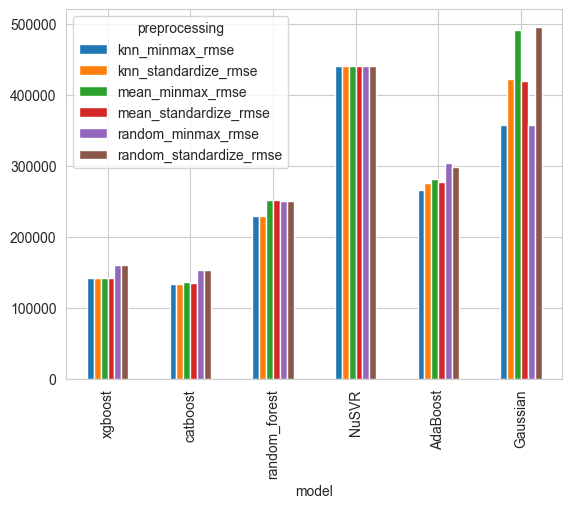

In [65]:
df_wide = pd.DataFrame({
    'xgboost': xgb_scores,
    'catboost': catboost_scores,
    'random_forest': random_forest_scores,
    'NuSVR': nusvr_scores,
    'AdaBoost': ada_boost_scores,
    'Gaussian': gussian_scores,
}).T
df_wide.index.name = 'model'
df_wide.columns.name = 'preprocessing'

df_wide.plot.bar()
df_wide


Learning rate set to 0.079593
0:	learn: 409313.1107466	test: 407176.7789791	best: 407176.7789791 (0)	total: 9.7ms	remaining: 9.69s
1:	learn: 388502.5066121	test: 386550.6111597	best: 386550.6111597 (1)	total: 15.6ms	remaining: 7.8s
2:	learn: 370319.4560137	test: 368893.7370438	best: 368893.7370438 (2)	total: 20.6ms	remaining: 6.86s
3:	learn: 353812.2962455	test: 352979.7572230	best: 352979.7572230 (3)	total: 27ms	remaining: 6.73s
4:	learn: 338639.1706113	test: 338242.8162415	best: 338242.8162415 (4)	total: 31.8ms	remaining: 6.33s
5:	learn: 324286.2085054	test: 324228.8112115	best: 324228.8112115 (5)	total: 36.6ms	remaining: 6.06s
6:	learn: 311148.9202975	test: 311539.2882022	best: 311539.2882022 (6)	total: 45.5ms	remaining: 6.46s
7:	learn: 298956.6200017	test: 299650.0632076	best: 299650.0632076 (7)	total: 52.7ms	remaining: 6.54s
8:	learn: 286177.0109365	test: 287259.2766342	best: 287259.2766342 (8)	total: 57.7ms	remaining: 6.35s
9:	learn: 274696.6112013	test: 276265.8513022	best: 2762

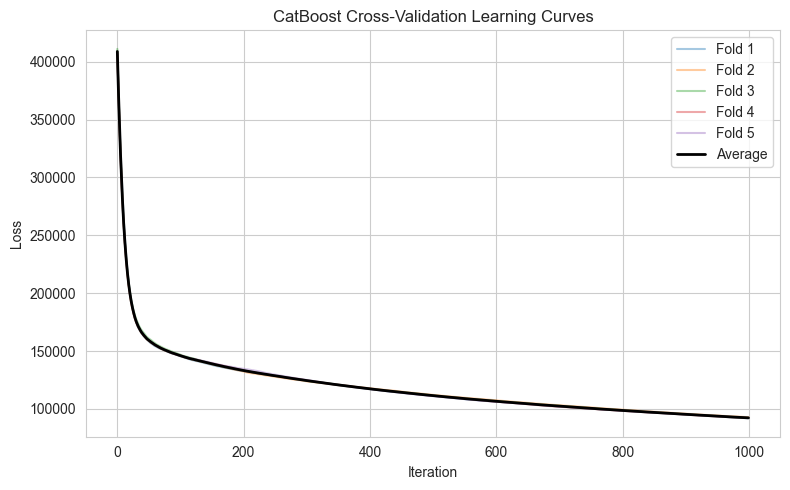

In [73]:
### Catboost 
all_curves = []
folds = split_set_into_cross_validation(knn_standardize_features, knn_target)

for i, (X_train, Y_train, X_eval, Y_eval) in enumerate(folds):
    model = CatBoostRegressor(eval_metric='RMSE', random_seed=2137)
    cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

    model.fit(
        X_train,
        Y_train,
        eval_set=(X_eval, Y_eval),
        cat_features=cat_features,
    )

    evals = model.get_evals_result()
    curve = evals['learn'][model.get_param('loss_function')]
    all_curves.append(curve)

min_len = min(len(c) for c in all_curves)
trimmed = [c[:min_len] for c in all_curves]
avg_curve = np.mean(np.vstack(trimmed), axis=0).tolist()

plt.figure(figsize=(8, 5))
for idx, curve in enumerate(trimmed, 1):
    plt.plot(curve, alpha=0.4, label=f'Fold {idx}')
plt.plot(avg_curve, color='black', linewidth=2, label='Average')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CatBoost Cross-Validation Learning Curves')
plt.legend()
plt.tight_layout()
plt.show()
